# Notebook to develop and test the ABC Rejection on DAP cell model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tqdm import tqdm

from delfi.distribution import Uniform
from dap.utils import obs_params_gbar, syn_current, load_current
from dap.dap_sumstats_step_mom import DAPSummaryStatsStepMoments
from dap import DAPcython
from dap.dap_simulator import DAPSimulator

In [2]:
from dap.cell_fitting.read_heka import (get_sweep_index_for_amp, get_i_inj_from_function,
                                        get_v_and_t_from_heka, shift_v_rest)

In [3]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

### General Settings Pick

In [4]:
n_samples = 100
n_summary = 17
dt = 0.01

### Get current

In [5]:
# load the data
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'    # best cell
I, v, t, t_on, t_off, dt = load_current(data_dir, protocol='IV', ramp_amp=1)

# generate syntetic data
paramseters, labels = obs_params_gbar(reduced_model=True)

In [6]:
dap = DAPcython(-75, paramseters)
U = dap.simulate(dt, t, I)

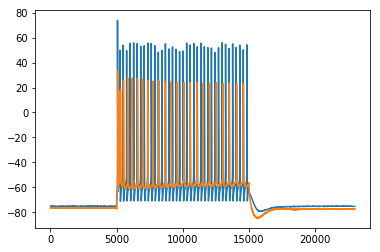

In [8]:
plt.plot(U);
plt.plot(v);

### Set up the model

In [9]:
sim = DAPSimulator(I, dt, -75, dim_param=1)
stats = DAPSummaryStatsStepMoments(t_on, t_off, n_summary=n_summary)

### Setup Priors

In [10]:
prior_min = np.array([0])
prior_max = np.array([1])
prior_unif = Uniform(lower=prior_min, upper=prior_max)

In [11]:
params = prior_unif.gen(n_samples=2000)
params

array([[ 0.33],
       [ 0.05],
       [ 0.24],
       ...,
       [ 0.12],
       [ 0.57],
       [ 0.63]])

### generate desired data

In [12]:
U = dap.simulate(dt, t, I)
y_o = {'data': v.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y = stats.calc([y_o])
y

array([[-76.63,  0.06, -53.89,  24.00,  24.00,  0.31, -0.01, -0.05,
        -0.05,  243.97,  3.66,  15.89,  70.74,  3.80,  6.20,  25.40]])

In [13]:
sum_stats = zscore(y, axis=1)
sum_stats

array([[-1.43, -0.27, -1.08,  0.09,  0.09, -0.27, -0.27, -0.27, -0.27,
         3.41, -0.22, -0.03,  0.80, -0.21, -0.18,  0.11]])

array([[-32.91,  27.05, -31.62,  137.00,  137.00, -0.18, -0.74,  0.27,
         0.67,  692.69,  0.82,  2.41,  3.90,  3.65,  3.65,  3.65]])

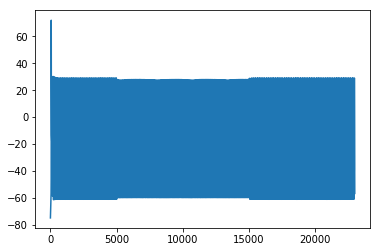

In [14]:
dap2 = DAPcython(-75, np.array([.3]))
U2 = dap2.simulate(dt, t, I)
plt.plot(U2);

y_o2 = {'data': U2.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y2 = stats.calc([y_o2])
y2

In [15]:
dap2 = DAPcython(-75, np.array([.47]))
U2 = dap2.simulate(dt, t, I)
plt.plot(U2);

array([[-23.40,  20.54, -22.84,  167.00,  167.00, -0.46, -0.44,  0.99,
        -0.47,  390.69,  0.47,  1.94,  1.99,  3.00,  2.95,  3.00]])

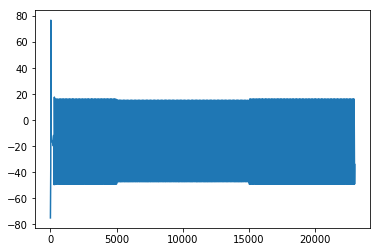

In [15]:
y_o2 = {'data': U2.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}
y2 = stats.calc([y_o2])
y2

## Repeat for 1000 in a loop

In [17]:
n_samples = 1000
eps = 1

In [18]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [19]:
norms = []

for p in tqdm(params):
#     print(p)
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 1000/1000 [20:20<00:00,  1.22s/it]


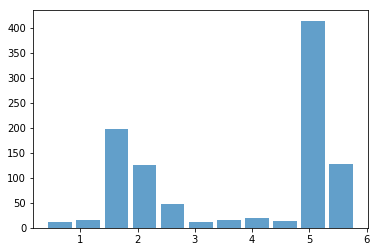

In [20]:
N1 = np.array(norms)
plt.hist(x=N1, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [21]:
scores = N1.transpose()[0]
arg_sorted = np.argsort(scores)

In [22]:
# rejection criterion
percent_accept = 10
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [23]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean

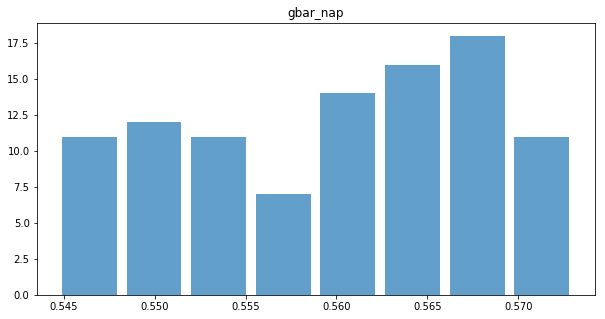

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

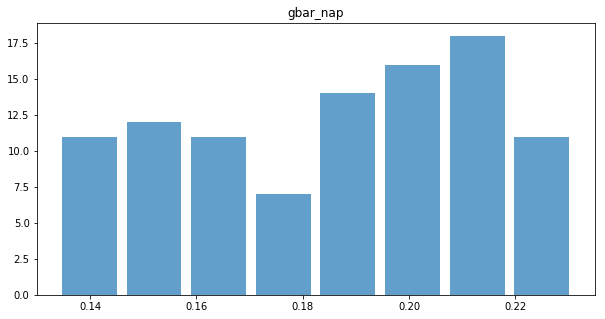

In [25]:
params_accept = params[arg_sorted[0:percent_criterion],:]
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:,0], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

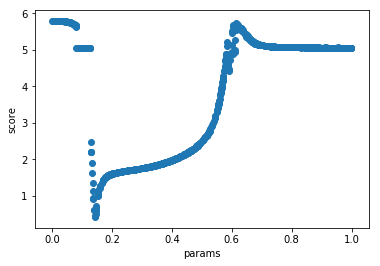

In [26]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

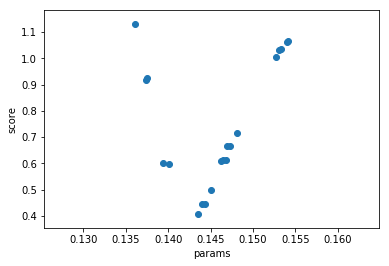

In [27]:
percent_accept = 2
percent_criterion = int(len(arg_sorted)*percent_accept/100)

p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

plt.scatter(p, s)
plt.xlabel('params')
plt.ylabel('score');

In [28]:
dap = DAPcython(-75, p[0])
U = dap.simulate(dt, t, I)
dap1 = DAPcython(-75, paramseters*10)
U1 = dap1.simulate(dt, t, I)

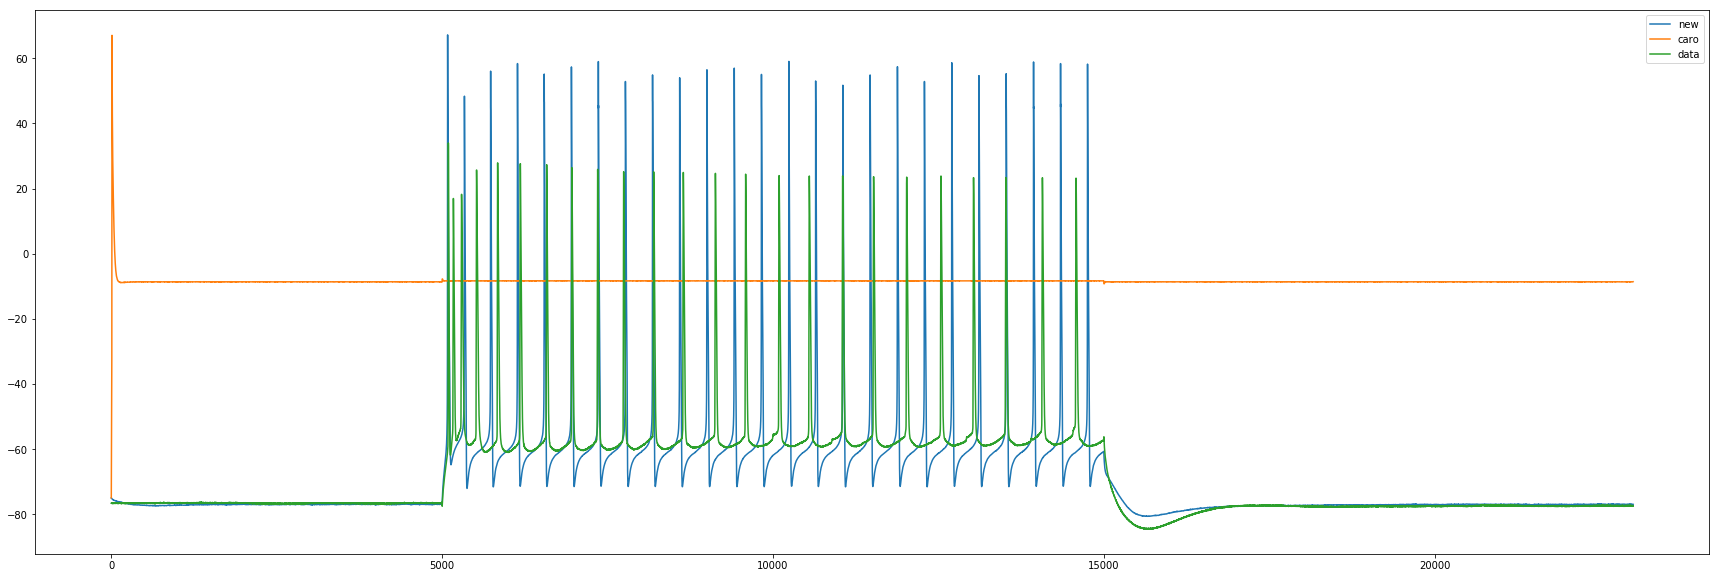

In [29]:
plt.subplots(1,1, figsize=(30, 10))
plt.plot(U, label='new');
plt.plot(U1, label='caro');
plt.plot(v, label='data');
plt.legend();

## Repeat for 5000 in a loop

In [55]:
n_samples = 5000
eps = 1

In [56]:
params = prior_unif.gen(n_samples=n_samples)
params_std = params.std()
params_mean = params.mean()

In [57]:
norms = []

for p in tqdm(params):
    x_o = sim.gen_single(p)
    y_obs = stats.calc([x_o])    
    obs_zt = zscore(y_obs, axis=1)
    dist_sum_stats = np.linalg.norm((sum_stats-obs_zt),axis=1)

    norms.append(dist_sum_stats)

100%|██████████| 5000/5000 [42:18<00:00,  1.97it/s]


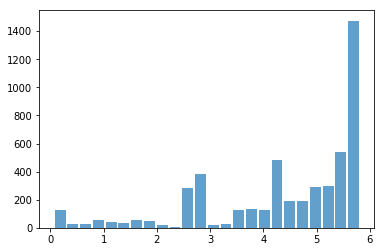

In [58]:
N5 = np.array(norms)
plt.hist(x=N5, bins='auto', alpha=0.7, rwidth=0.85);

## Sort the stuff

In [59]:
scores = N5.transpose()[0]
arg_sorted = np.argsort(scores)

In [60]:
# rejection criterion
percent_accept = 1
percent_criterion = int(len(arg_sorted)*percent_accept/100)

In [61]:
# rejection (or more positively, acceptance) of the z-scored parameters 'params' and inverse z-scoring of the accepted parameters
params_accept = params[arg_sorted[0:percent_criterion],:]*params_std + params_mean
# params_accept = params[arg_sorted[0:percent_criterion],:]
params_accept = params[arg_sorted[0:percent_criterion],:]*params_mean + params_std

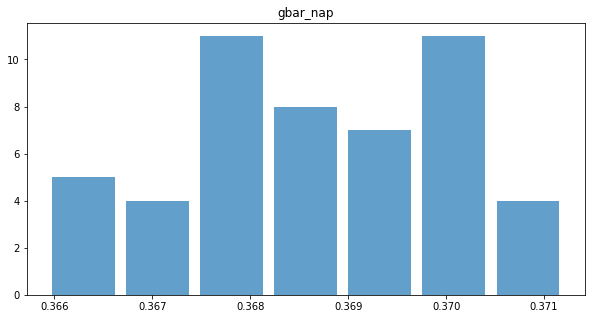

In [62]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.hist(x=params_accept[:], bins='auto', alpha=0.7, rwidth=0.85);
ax.set_title(labels[0]);

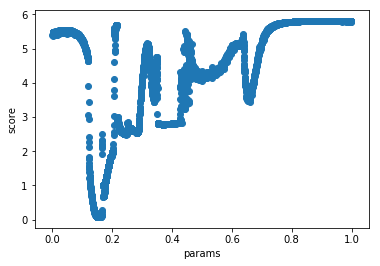

In [63]:
plt.scatter(params, scores)
plt.xlabel('params')
plt.ylabel('score');

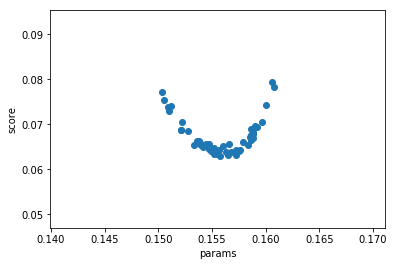

In [64]:
p = params[arg_sorted[0:percent_criterion],:]
s = scores[arg_sorted[0:percent_criterion]]

plt.scatter(p, s)
plt.xlabel('params')
plt.ylabel('score');

In [65]:
p[0]

array([ 0.16])

In [68]:
s[0]

0.06303119911289812

In [32]:
dap = DAPcython(-75, p[0])
U = dap.simulate(dt, t, I)
dap1 = DAPcython(-75, paramseters)
U1 = dap1.simulate(dt, t, I)

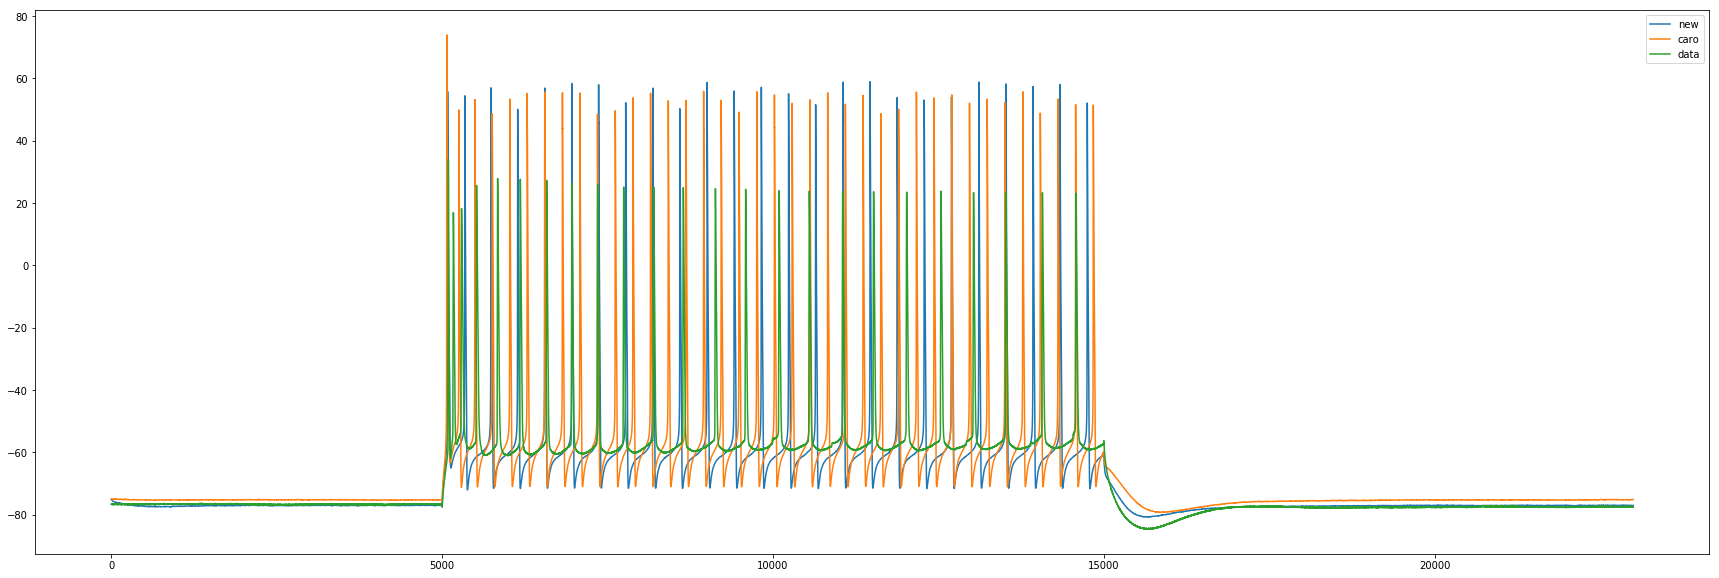

In [33]:
plt.subplots(1,1, figsize=(30, 10))
plt.plot(U, label='new');
plt.plot(U1, label='caro');
plt.plot(v, label='data');
plt.legend();

In [36]:
print(p[0])
print(paramseters[0])

[ 0.14]
0.1527
